#### Load necessary packages

In [1]:
import numpy as np
import xarray as xr
import pickle
import math
import matplotlib.pyplot as plt
import warnings
import cftime
import scipy

In [2]:
glodap = scipy.io.loadmat("../data/GLODAPv2.2023_Merged_Master_File.mat")
glodap.keys()

dict_keys(['__header__', '__version__', '__globals__', 'G2cruise', 'G2station', 'G2region', 'G2cast', 'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute', 'G2latitude', 'G2longitude', 'G2bottomdepth', 'G2maxsampdepth', 'G2bottle', 'G2pressure', 'G2depth', 'G2temperature', 'G2theta', 'G2salinity', 'G2salinityf', 'G2salinityqc', 'G2sigma0', 'G2sigma1', 'G2sigma2', 'G2sigma3', 'G2sigma4', 'G2gamma', 'G2oxygen', 'G2oxygenf', 'G2oxygenqc', 'G2aou', 'G2aouf', 'G2nitrate', 'G2nitratef', 'G2nitrateqc', 'G2nitrite', 'G2nitritef', 'G2silicate', 'G2silicatef', 'G2silicateqc', 'G2phosphate', 'G2phosphatef', 'G2phosphateqc', 'G2tco2', 'G2tco2f', 'G2tco2qc', 'G2talk', 'G2talkf', 'G2talkqc', 'G2fco2', 'G2fco2f', 'G2fco2temp', 'G2phts25p0', 'G2phts25p0f', 'G2phtsinsitutp', 'G2phtsinsitutpf', 'G2phtsqc', 'G2cfc11', 'G2pcfc11', 'G2cfc11f', 'G2cfc11qc', 'G2cfc12', 'G2pcfc12', 'G2cfc12f', 'G2cfc12qc', 'G2cfc113', 'G2pcfc113', 'G2cfc113f', 'G2cfc113qc', 'G2ccl4', 'G2pccl4', 'G2ccl4f', 'G2ccl4qc', 'G2sf6', '

In [3]:
glodap["G2talk"].shape
np.unique(glodap["G2tco2f"])

array([0., 2., 9.])

In [4]:
# cut out values deeper than 10m
glodap_surf = {}
is_surf = glodap["G2depth"] <= 10

for key in glodap.keys():
    if isinstance(glodap[key], np.ndarray) and glodap[key].shape == is_surf.shape:
        glodap_surf[key] = glodap[key][is_surf]

In [5]:
glodap_surf.keys()

dict_keys(['G2cruise', 'G2station', 'G2region', 'G2cast', 'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute', 'G2latitude', 'G2longitude', 'G2bottomdepth', 'G2maxsampdepth', 'G2bottle', 'G2pressure', 'G2depth', 'G2temperature', 'G2theta', 'G2salinity', 'G2salinityf', 'G2salinityqc', 'G2sigma0', 'G2sigma1', 'G2sigma2', 'G2sigma3', 'G2sigma4', 'G2gamma', 'G2oxygen', 'G2oxygenf', 'G2oxygenqc', 'G2aou', 'G2aouf', 'G2nitrate', 'G2nitratef', 'G2nitrateqc', 'G2nitrite', 'G2nitritef', 'G2silicate', 'G2silicatef', 'G2silicateqc', 'G2phosphate', 'G2phosphatef', 'G2phosphateqc', 'G2tco2', 'G2tco2f', 'G2tco2qc', 'G2talk', 'G2talkf', 'G2talkqc', 'G2fco2', 'G2fco2f', 'G2fco2temp', 'G2phts25p0', 'G2phts25p0f', 'G2phtsinsitutp', 'G2phtsinsitutpf', 'G2phtsqc', 'G2cfc11', 'G2pcfc11', 'G2cfc11f', 'G2cfc11qc', 'G2cfc12', 'G2pcfc12', 'G2cfc12f', 'G2cfc12qc', 'G2cfc113', 'G2pcfc113', 'G2cfc113f', 'G2cfc113qc', 'G2ccl4', 'G2pccl4', 'G2ccl4f', 'G2ccl4qc', 'G2sf6', 'G2psf6', 'G2sf6f', 'G2sf6qc', 'G2c13', 'G2c1

In [6]:
glodap_surf["G2talk"].shape

(85072,)

In [7]:
glodap_all = {}
talk_tco2_good = np.logical_and(glodap_surf["G2talk"] > 1000,
                                glodap_surf["G2tco2"] > 1000)

temp_salt_good = np.logical_and(np.isfinite(glodap_surf["G2temperature"]),
                               np.isfinite(glodap_surf["G2salinity"]))

four_drivers_good = np.logical_and(talk_tco2_good, temp_salt_good)

silicate_phosphate_good = np.logical_and(glodap_surf["G2silicate"] > 0,
                                         glodap_surf["G2phosphate"] > 0)

all_drivers_good = np.logical_and(four_drivers_good, silicate_phosphate_good)

ph_fco2_good = np.logical_and(np.isfinite(glodap_surf["G2phtsinsitutp"]),
                              glodap_surf["G2fco2"] <= 1000)

all_good = np.logical_and(all_drivers_good, ph_fco2_good)

is_between_1993_2022 = np.logical_and(glodap_surf["G2year"] >= 1993,
                                      glodap_surf["G2year"] <= 2022)


for key in ["G2talk", "G2tco2", "G2silicate", "G2phosphate",
           "G2year", "G2month", "G2latitude", "G2longitude",
           "G2temperature", "G2salinity", "G2phtsinsitutp", "G2fco2"]:
    glodap_all[key] = glodap_surf[key][np.logical_and(all_good, is_between_1993_2022)]

In [8]:
print("glodap_all has {} data points.".format(glodap_all["G2talk"].shape[0]))
print("")
print("Do quality checks of the data:")
print("glodap_all['G2month'] between {} and {}".format(
    np.min(glodap_all["G2month"]), np.max(glodap_all["G2month"])))
print("")
print("glodap_all['G2year'] between {} and {}".format(
    np.min(glodap_all["G2year"]), np.max(glodap_all["G2year"])))
print("")
print("glodap_all['G2latitude'] between {} and {}".format(
    np.min(glodap_all["G2latitude"]), np.max(glodap_all["G2latitude"])))
print("")
print("glodap_all['G2longitude'] between {} and {}".format(
    np.min(glodap_all["G2longitude"]), np.max(glodap_all["G2longitude"])))
print("")
print("glodap_all['G2talk'] between {} and {}".format(
    np.min(glodap_all["G2talk"]), np.max(glodap_all["G2talk"])))
print("")
print("glodap_all['G2tco2'] between {} and {}".format(
    np.min(glodap_all["G2tco2"]), np.max(glodap_all["G2tco2"])))
print("")
print("glodap_all['G2silicate'] between {} and {}".format(
    np.min(glodap_all["G2silicate"]), np.max(glodap_all["G2silicate"])))
print("")
print("glodap_all['G2phosphate'] between {} and {}".format(
    np.min(glodap_all["G2phosphate"]), np.max(glodap_all["G2phosphate"])))
print("")
print("glodap_all['G2temperature'] between {} and {}".format(
    np.min(glodap_all["G2temperature"]), np.max(glodap_all["G2temperature"])))
print("")
print("glodap_all['G2salinity'] between {} and {}".format(
    np.min(glodap_all["G2salinity"]), np.max(glodap_all["G2salinity"])))
print("")
print("glodap_all['G2phtsinsitutp'] between {} and {}".format(
    np.min(glodap_all["G2phtsinsitutp"]), np.max(glodap_all["G2phtsinsitutp"])))
print("")
print("glodap_all['G2fco2'] between {} and {}".format(
    np.min(glodap_all["G2fco2"]), np.max(glodap_all["G2fco2"])))

glodap_all has 18168 data points.

Do quality checks of the data:
glodap_all['G2month'] between 1.0 and 12.0

glodap_all['G2year'] between 1993.0 and 2021.0

glodap_all['G2latitude'] between -78.04 and 89.987

glodap_all['G2longitude'] between -179.89 and 235.9997

glodap_all['G2talk'] between 1033.9 and 2829.4

glodap_all['G2tco2'] between 1018.7 and 2664.2

glodap_all['G2silicate'] between 0.0095 and 133.2

glodap_all['G2phosphate'] between 0.00092915 and 2.68

glodap_all['G2temperature'] between -1.9081 and 31.912

glodap_all['G2salinity'] between 0.1173 and 39.152

glodap_all['G2phtsinsitutp'] between 7.5443 and 9.3666

glodap_all['G2fco2'] between 21.457 and 999.6


In [9]:
mean_array_all = [np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan),
                 np.full((360, 180, 360), np.nan)]

num_array_all = np.zeros((360, 180, 360))

# grid GLODAP data with all four variables available
for i in range(len(glodap_all["G2year"])):
    time_index = int(12 * (
        glodap_all["G2year"][i] - 1993) + glodap_all["G2month"][i] - 1)
    lat_index = math.floor(glodap_all["G2latitude"][i]) + 90
    lon_index = math.floor(glodap_all["G2longitude"][i]) + 180
    # if longitude is given as 180.5°E, this should be index 0
    # (since corresponding to between -180°E and -179°E)
    if lon_index >= 360: 
        lon_index -= 360
    
    num_array_all[time_index, lat_index, lon_index] += 1
    num_obs = num_array_all[time_index, lat_index, lon_index]

    if num_obs == 1:
        for j, key in enumerate(["G2talk", "G2tco2", "G2silicate", "G2phosphate",
           "G2temperature", "G2salinity", "G2phtsinsitutp", "G2fco2"]):
            mean_array_all[j][time_index, lat_index, lon_index] = glodap_all[key][i]
    elif num_obs > 1:
        for j, key in enumerate(["G2talk", "G2tco2", "G2silicate", "G2phosphate",
           "G2temperature", "G2salinity", "G2phtsinsitutp", "G2fco2"]):
            mean_array_all[j][time_index, lat_index, lon_index] = (
                (num_obs-1) / num_obs *  mean_array_all[j][
                            time_index, lat_index, lon_index]
                         + 1 / num_obs * glodap_all[key][i])


Number of GLODAP samples: 18168
Number of grid cells with GLODAP samples: 10910


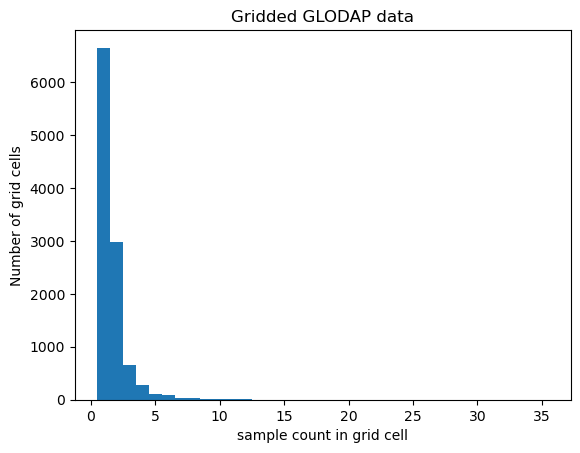

In [10]:
plt.hist(num_array_all[num_array_all > 0], bins=np.arange(0.5, 36.5))
plt.title("Gridded GLODAP data")
plt.xlabel("sample count in grid cell")
plt.ylabel("Number of grid cells")
print("Number of GLODAP samples: {}".format(
    int(np.sum(num_array_all))))
print("Number of grid cells with GLODAP samples: {}".format(
    int(np.sum(np.isfinite(mean_array_all[0])))))

Histograms of gridded GLODAP data for all four variables


Text(0.5, 1.0, 'fCO2')

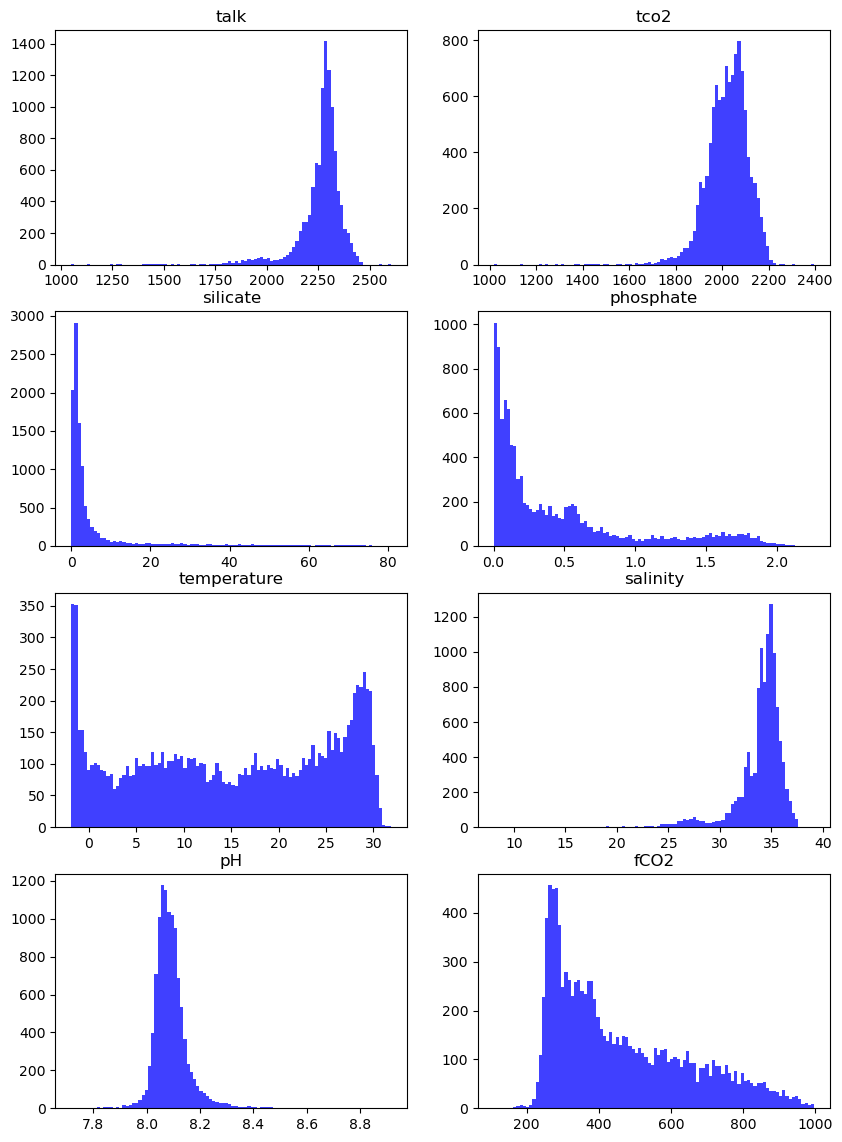

In [11]:
print("Histograms of gridded GLODAP data for all four variables")
fig, axs = plt.subplots(4, 2, figsize=(10, 14))
axs[0, 0].hist(mean_array_all[0][np.isfinite(mean_array_all[0])],
               bins=100, alpha=0.75, color='blue')
axs[0, 0].set_title('talk')

axs[0, 1].hist(mean_array_all[1][np.isfinite(mean_array_all[1])],
               bins=100, alpha=0.75, color='blue')
axs[0, 1].set_title('tco2')

axs[1, 0].hist(mean_array_all[2][np.isfinite(mean_array_all[2])],
               bins=100, alpha=0.75, color='blue')
axs[1, 0].set_title('silicate')

axs[1, 1].hist(mean_array_all[3][np.isfinite(mean_array_all[3])],
               bins=100, alpha=0.75, color='blue')
axs[1, 1].set_title('phosphate')

axs[2, 0].hist(mean_array_all[4][np.isfinite(mean_array_all[2])],
               bins=100, alpha=0.75, color='blue')
axs[2, 0].set_title('temperature')

axs[2, 1].hist(mean_array_all[5][np.isfinite(mean_array_all[3])],
               bins=100, alpha=0.75, color='blue')
axs[2, 1].set_title('salinity')

axs[3, 0].hist(mean_array_all[6][np.isfinite(mean_array_all[2])],
               bins=100, alpha=0.75, color='blue')
axs[3, 0].set_title('pH')

axs[3, 1].hist(mean_array_all[7][np.isfinite(mean_array_all[3])],
               bins=100, alpha=0.75, color='blue')
axs[3, 1].set_title('fCO2')

#### Check spatial and temporal resolution of data

/tmp/ipykernel_4903/498410948.py:1: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(np.nanmean(mean_array_all[0], axis=0))


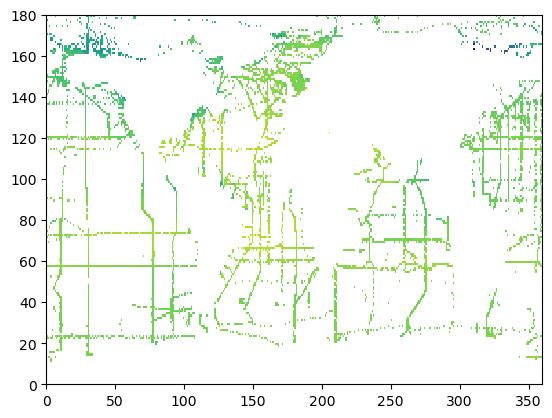

In [12]:
plt.pcolormesh(np.nanmean(mean_array_all[0], axis=0))

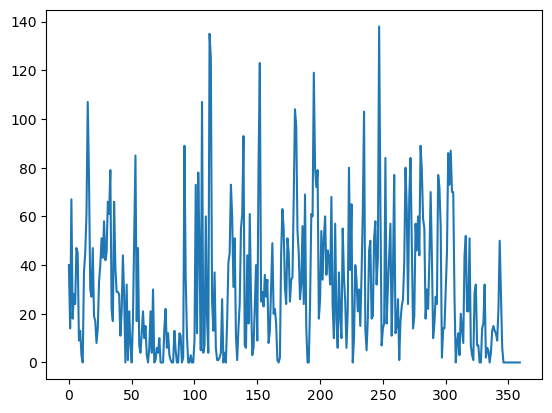

In [13]:
plt.plot(np.sum(np.isfinite(mean_array_all[0]), axis=(1, 2)))

In [14]:
#create coordinates for xarray dataset for export
latitudes = np.arange(-89.5, 90)
longitudes = np.arange(-179.5, 180)

start_date = cftime.DatetimeGregorian(1993, 1, 15)
end_date = cftime.DatetimeGregorian(2023, 1, 15)
times = xr.cftime_range(start=start_date, end=end_date, freq="M")

In [15]:
ds_out_all = xr.Dataset()
for j, key in enumerate(["G2talk", "G2tco2", "G2silicate", "G2phosphate",
           "G2temperature", "G2salinity", "G2phtsinsitutp", "G2fco2"]):
    ds_out_all[key] = xr.DataArray(
        mean_array_all[j], coords ={"time": times, "latitude": latitudes, "longitude": longitudes}
    ).astype('float32')

In [16]:
ds_out_all

<xarray.Dataset>
Dimensions:         (time: 360, latitude: 180, longitude: 360)
Coordinates:
  * time            (time) object 1993-01-31 00:00:00 ... 2022-12-31 00:00:00
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    G2talk          (time, latitude, longitude) float32 nan nan nan ... nan nan
    G2tco2          (time, latitude, longitude) float32 nan nan nan ... nan nan
    G2silicate      (time, latitude, longitude) float32 nan nan nan ... nan nan
    G2phosphate     (time, latitude, longitude) float32 nan nan nan ... nan nan
    G2temperature   (time, latitude, longitude) float32 nan nan nan ... nan nan
    G2salinity      (time, latitude, longitude) float32 nan nan nan ... nan nan
    G2phtsinsitutp  (time, latitude, longitude) float32 nan nan nan ... nan nan
    G2fco2          (time, latitude, longitude) float32 nan nan nan ... nan nan

In [29]:
ds_out_all.to_netcdf("../data/GLODAPv2.2023_gridded_talk_tco2_silicate_phosphate_pH_fCO2.nc")

# Double check gridding routing using mock data

In [32]:
glodap_mock = {}
glodap_mock["G2year"] = np.random.randint(1993, high=2022, size=1000, dtype=int).astype("float")
glodap_mock["G2month"] = np.random.randint(1, high=13, size=1000, dtype=int).astype("float")
glodap_mock["G2latitude"] = np.random.uniform(-78.04, 89.987, size=1000)
glodap_mock["G2longitude"] = np.random.uniform(-179.89, 235.9997, size=1000)

In [33]:
print("glodap_mock['G2month'] between {} and {}".format(
    np.min(glodap_mock["G2month"]), np.max(glodap_mock["G2month"])))
print("")
print("glodap_mock['G2year'] between {} and {}".format(
    np.min(glodap_mock["G2year"]), np.max(glodap_mock["G2year"])))
print("")
print("glodap_mock['G2latitude'] between {} and {}".format(
    np.min(glodap_mock["G2latitude"]), np.max(glodap_mock["G2latitude"])))
print("")
print("glodap_mock['G2longitude'] between {} and {}".format(
    np.min(glodap_mock["G2longitude"]), np.max(glodap_mock["G2longitude"])))

glodap_mock['G2month'] between 1.0 and 12.0

glodap_mock['G2year'] between 1993.0 and 2021.0

glodap_mock['G2latitude'] between -77.93474496035938 and 89.67779867963246

glodap_mock['G2longitude'] between -179.86437172820104 and 235.56129626498534


In [41]:
grid_values = []
times = []
lats = []
lons = []


for i in range(len(glodap_mock["G2year"])):
    time_index = int(12 * (
        glodap_mock["G2year"][i] - 1993) + glodap_mock["G2month"][i] - 1)
    lat_index = math.floor(glodap_mock["G2latitude"][i]) + 90
    lon_index = math.floor(glodap_mock["G2longitude"][i]) + 180
    # if longitude is given as 180.5°E, this should be index 0
    # (since corresponding to between -180°E and -179°E)
    if lon_index >= 360: 
        lon_index -= 360
    times.append("{}-{}".format(int(glodap_mock["G2year"][i]),
                                int(glodap_mock["G2month"][i])))
    lats.append(glodap_mock["G2latitude"][i])
    lons.append(glodap_mock["G2longitude"][i])
    grid_values.append((ds_out_all.time[time_index].values,
                        ds_out_all.latitude[lat_index].values,
                        ds_out_all.longitude[lon_index].values))

In [42]:
for i in range(10):
    print(times[i])
    print(lats[i])
    print(lons[i])
    print(grid_values[i])

2019-12
81.88601863837808
-157.44444944942265
(array(cftime.DatetimeGregorian(2019, 12, 31, 0, 0, 0, 0, has_year_zero=False),
      dtype=object), array(81.5), array(-157.5))
2016-12
-44.139500331585474
212.47808797880384
(array(cftime.DatetimeGregorian(2016, 12, 31, 0, 0, 0, 0, has_year_zero=False),
      dtype=object), array(-44.5), array(-147.5))
2007-3
-73.98323047198713
-164.43168197638647
(array(cftime.DatetimeGregorian(2007, 3, 31, 0, 0, 0, 0, has_year_zero=False),
      dtype=object), array(-73.5), array(-164.5))
2008-9
25.65826140619049
221.87514416889587
(array(cftime.DatetimeGregorian(2008, 9, 30, 0, 0, 0, 0, has_year_zero=False),
      dtype=object), array(25.5), array(-138.5))
2013-10
28.331716246068694
-45.593822910105644
(array(cftime.DatetimeGregorian(2013, 10, 31, 0, 0, 0, 0, has_year_zero=False),
      dtype=object), array(28.5), array(-45.5))
2009-11
-25.827280737876116
109.08326011639946
(array(cftime.DatetimeGregorian(2009, 11, 30, 0, 0, 0, 0, has_year_zero=False),